# 1.2.4 Calculating Infra-Red (IR) Spectrum

It is possible to compute IR spectrum from a normal mode finite displacement calculation. Traditionally, quantum chemistry codes compute the IR intensities employing double-harmonic approximation, where the transition probability (oscillator strength) is proportional to the square of the first derivative of the total dipole moment of the molecule with respect to the normal coordinates. Here we will use the same apprach, where the normal mode derivative of the dipole moment would be computed using finite displacements, as implemented in PyEPFD. In this example, we will use CO2 molecule, however, the approach is applicable to periodic solids; see the following paper: https://onlinelibrary.wiley.com/doi/10.1002/anie.202420680 and section 17 of the associated supporting information for a recent example.

Here, the steps are very similar to the previous exercises: 1.2.1 and 1.2.2. There are two differences. First we have to instruct Qbox code to compute the total dipole monent, which can be done using the "set polarization MLWF_REF" command. Secondly, current implementation of Qbox does not compute correct dipole moment if we keep empty orbitals, therefore we have to use default nempty = 0. We are going to use the xyz file that we created in the exercise 1.2.1 but create a new input deck for Qbox calculations. Lets do it.

In [2]:
%run ../../../utils/qbox_utils/xyz2qb.py enmfd_phonon.xyz

File enmfd_phonon.xyz has 3 number of atoms in each frame and a total 19 number of frames.
No of species: 2
Present species are: 
O
C
The file enmfd_phonon.xyz is an i-PI output with pos_unit: angstrom and cell_unit: angstrom
Enter start frame number: (Default = 1) 
Enter last frame number: (Default = 19) 
Enter step frame: (Default = 1) 
Enter qbox command for 1st iteration: (Default = '  randomize_wf, run -atomic_density 0 100 10')
Hint: more than one commands should be separated by a comma.
 set polarization MLWF_REF, randomize_wf, run -atomic_density 0 100 10
Enter qbox run command: (Default = '  run 0 60 10')
Hint: more than one commands should be separated by a comma.
 run 0 100 10
Enter qbox plot command: (Default = ' None')
Hints:
      (1) Example: plot options filename (without .cube extension) 
      (2) More than one commands should be separated by a comma.

Enter qbox spectrum command: (Default = ' None')
Hints:
      (1) Example: spectrum options filename (without .dat ex

As usual, lets have a look at the generated qbox input deck.

In [3]:
%%bash
cat ir_spectra.i

 species  O  ../pseudos/O_ONCV_PBE-1.0.xml
 species  C  ../pseudos/C_ONCV_PBE-1.0.xml
# Frame 1/19 from enmfd_phonon.xyz#
 set cell     20.000000     0.000000     0.000000     0.000000    20.000000     0.000000     0.000000     0.000000    20.000000
 atom   O1   O     0.000000       0.000000       2.186665
 atom   O2   O     0.000000       0.000000      -2.186662
 atom   C3   C     0.000000       0.000000      -0.000003
 set ecut  50.00
 set xc B3LYP 
 set wf_dyn PSDA 
 set scf_tol 1.00e-12
 set polarization MLWF_REF
 randomize_wf
 run -atomic_density 0 100 10
# Frame 2/19 from enmfd_phonon.xyz#
 set cell     20.000000     0.000000     0.000000     0.000000    20.000000     0.000000     0.000000     0.000000    20.000000
 move   O1   to       -0.000000      -0.000000       2.475340
 move   O2   to       -0.000000      -0.000000      -1.897987
 move   C3   to       -0.000000      -0.000000       0.288672
 run 0 100 10 
# Frame 3/19 from enmfd_phonon.xyz#
 set cell     20.000000     0.00

The next step is to submit those jobs and wait until all calculations finished properly. Once the calculations are finished, the obox outputs must be post-processed to compute the frequency and oscillator strengths and compute the spectra using these informations. Lets do that using the qbox output ir_spectra.r. We also need the output when we performed the normal mode displacement, i.e., the output when we ran ionic_mover class in exercise 1.2.1. We have copied it into the file enmfd.log.

Lets begin post-process all the information and compute the spectra.

In [1]:
from pyepfd.vibrational_spectra import *
# Initiating the qbox_ir class
co2 = qbox_ir(file_path = 'enmfd.log',
              qb_output_path = './',
              qb_prefix = 'ir_spectra',
              asr = 'lin',
              save_path = 'co2-freq-osc-str.npz')
# calculating the frequency and oscillator strength
# using normal mode finite-displacement
co2.calc_freq_osc_str()
# Printing the frequency and oscillator strengths
co2.print_freq_osc_str()
# Saving the freq, and oscillator strengths at
# co2-freq-osc-str.npz
co2.save()

                                                 
          ███████████                            
         ░░███░░░░░███                           
          ░███    ░███ █████ ████                
          ░██████████ ░░███ ░███                 
          ░███░░░░░░   ░███ ░███                 
          ░███         ░███ ░███                 
          █████        ░░███████                 
         ░░░░░          ░░░░░███                 
                        ███ ░███                 
                       ░░██████                  
                        ░░░░░░                   
 ██████████ ███████████  ███████████ ██████████  
░░███░░░░░█░░███░░░░░███░░███░░░░░░█░░███░░░░███ 
 ░███  █ ░  ░███    ░███ ░███   █ ░  ░███   ░░███
 ░██████    ░██████████  ░███████    ░███    ░███
 ░███░░█    ░███░░░░░░   ░███░░░█    ░███    ░███
 ░███ ░   █ ░███         ░███  ░     ░███    ███ 
 ██████████ █████        █████       ██████████  
░░░░░░░░░░ ░░░░░        ░░░░░       ░░░░░░░░░░   


/home/arpan/.local/lib/python3.8/site-packages/pyepfd/vibrational_spectra.py:265: RuntimeWarning: invalid value encountered in sqrt
  omega = np.sqrt(hessian) * ha2unit[freq_unit]


The print method would print all the modes that we have computed. As usual, the first 5 modes are not meaningful as they represent rigid body rotation and translations of the CO2 molecule. The save command would save only the last 4 modes as we have used asr = 'lin'. Lets have a look at the data contained in co2-freq-osc-str.npz. 

In [2]:
import numpy as np
freq_osc_str = np.load('co2-freq-osc-str.npz')
print(freq_osc_str['omega'])
print(freq_osc_str['osc_str'])

[ 676.08784227  676.08784227 1345.44790558 2361.84521762]
[1.68502722e-05 1.68501808e-05 2.26567404e-13 3.80549776e-04]


We know that degenerate bending modes (676.0 cm-1) and asymetric stretching modes (2361.8 cm-1) are IR active as they involves change of total dipole moment, while the symmetric stretching mode (1345.4 cm-1) is not IR active. Indeed we see that the symmetric stretching mode has very low intensity. Lets use this data to compute a spectra. 

The co2 class has these saved data, therefore we can directly use a method named calc_spectra() available within the co2 class. Lets do it and plot the spectra using matplotlib. We will do it using Lorentzinan broadening using three different broadening parameter of 100 cm-1.Note, if the co2-freq-osc-str.npz file is already present, then those data can be read and compute the spectra using the add_broadening() method, see the documentation for the vibrational_spectra module for more informations. 

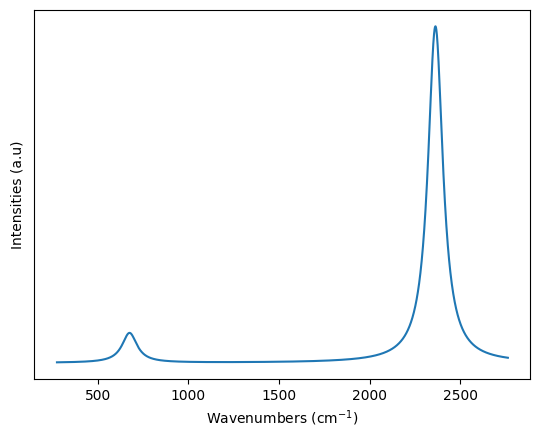

In [3]:
import matplotlib.pyplot as plt


co2.calc_spectra(line_profile='Lorentzian', 
                line_param = 100, step = 1,
                save_path = 'co2_ir.npz')
plt.xlabel("Wavenumbers (cm$^{-1}$)")
plt.ylabel("Intensities (a.u)")
plt.yticks([]) # Showing no y-ticks as units are arbitrary
plt.plot(co2.spectra[0],co2.spectra[1])
plt.show()

This would also create a co2_ir.npz, which could be later used to redraw the spectra as shown below.


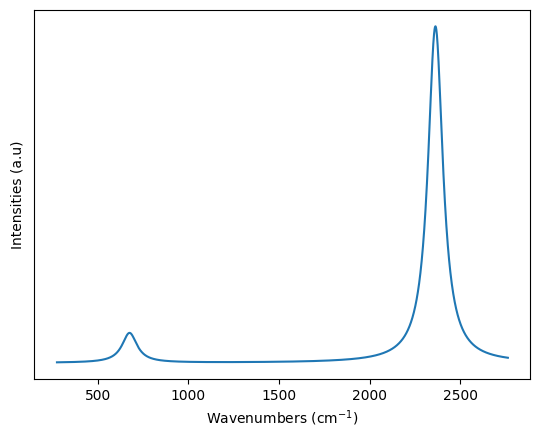

In [4]:
co2_spectra = np.load("co2_ir.npz")['spectra']
plt.xlabel("Wavenumbers (cm$^{-1}$)")
plt.ylabel("Intensities (a.u)")
plt.yticks([]) # Showing no y-ticks as units are arbitrary
plt.plot(co2_spectra[0],co2_spectra[1])
plt.show()